In [1]:
import numpy as np 
import astropy.units as u
from astropy.cosmology import z_at_value
# -- gqp_mc --
from gqp_mc import util as UT
from gqp_mc import fitters as Fitters
# -- plotting --
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [2]:
speculate = Fitters.iSpeculator()
speculate_fsps = Fitters.iSpeculator(model_name='fsps')

In [3]:
theta = np.load('_theta.npy')

In [4]:
spectrum = speculate._emulator(theta)

In [5]:
w_fsps, spectrum_fsps = speculate_fsps._fsps_model(theta)

/Users/ChangHoon/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/gqp_mc-0.1-py3.7.egg/gqp_mc/fitters.py:1973: RuntimeWarning: divide by zero encountered in log10
  self._ssp.params['logzsol'] = np.log10(z/0.0190) # log(Z/Zsun)


No handles with labels found to put in legend.


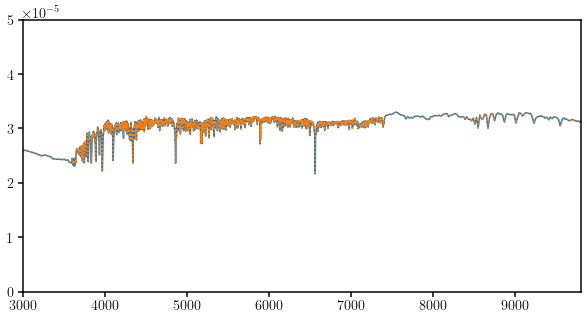

In [6]:
fig = plt.figure(figsize=(10,5))
sub = plt.subplot(111)
sub.plot(speculate._emu_wave, spectrum)
sub.plot(w_fsps, spectrum_fsps, ls=':')

sub.set_xlim(3e3, 9800.)
sub.set_ylim(0.,0.00005)
sub.legend(loc='upper right', fontsize=20)

In [7]:
_theta = np.array([0.]+list(theta[:-1]))

zred = z_at_value(speculate.cosmo.age, theta[-1] * u.Gyr)

In [8]:
_w, _spec = speculate.model(_theta, zred=zred, dont_transform=True)

In [9]:
_w_fsps, _spec_fsps = speculate_fsps.model(_theta, zred=zred, dont_transform=True)

/Users/ChangHoon/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/gqp_mc-0.1-py3.7.egg/gqp_mc/fitters.py:1973: RuntimeWarning: divide by zero encountered in log10
  self._ssp.params['logzsol'] = np.log10(z/0.0190) # log(Z/Zsun)


No handles with labels found to put in legend.


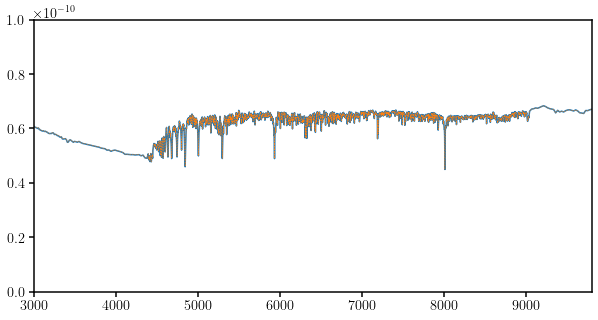

In [10]:
fig = plt.figure(figsize=(10,5))
sub = plt.subplot(111)
sub.plot(_w, _spec, c='C0')
sub.plot(_w_fsps, _spec_fsps, c='C1', lw=0.5, ls='--')
sub.set_xlim(3e3, 9800.)
sub.set_ylim(0.,1e-10)
sub.legend(loc='upper right', fontsize=20)